In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *

import matplotlib.animation as animation
from scipy.interpolate import griddata
import datetime

## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
/Users/bxin/Library/CloudStorage/OneDrive-SharedLibraries-GMTOCorp/M1S Portal - Documents/influnce_matrix_files/OA_influence_matrices_all/OA_surface_normal_165SA_09Jan2025/
Afz =  (27547, 165)
Afx =  (27547, 165)
Afy =  (27547, 165)
U matrix (27547, 165)
S matrix (165, 165)
V matrix (165, 165)
N node =  28789
number of Mirror Front surface TCs =  48
number of Mirror Back surface TCs =  48
number of Mirror Middle TCs =  16


<Figure size 640x480 with 0 Axes>

In [3]:
inputfile = '../ml_data_interface/m1s3_tc_20241209.txt'
df = pd.read_csv(inputfile, skiprows=14, nrows=154)
df
#verify that table below is 1 row more than what we need

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0
152,DATA,CTCIB006,0.000000,0.000000,5.0,31.0,5.0,1.0,0.0


In [4]:
# Remove the last row
df = df.iloc[:-1]

In [5]:
# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()
# Step 2: Remove leading/trailing spaces from all string values in the DataFrame
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:
df

,HEADER,Name,X,Y,Which_Scanner,Scanner_channel,Scanner_Index,Valid,Offset
0,DATA,TC1REF,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
1,DATA,MTCIN002B,-0.332903,-0.474510,0.0,1.0,0.0,1.0,0.0
2,DATA,MTCIN002M,-0.332903,-0.474510,0.0,2.0,0.0,1.0,0.0
3,DATA,MTCIN002F,-0.332892,-0.384404,0.0,3.0,0.0,1.0,0.0
4,DATA,MTC013B,-1.742551,-1.198263,0.0,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
148,DATA,CTCUP012,0.000000,0.000000,5.0,23.0,5.0,1.0,0.0
149,DATA,CTCAA003,0.000000,0.000000,5.0,24.0,5.0,1.0,0.0
150,DATA,CTCCW003W,0.000000,0.000000,5.0,25.0,5.0,1.0,0.0
151,DATA,CTCCW003F,0.000000,0.000000,5.0,26.0,5.0,1.0,0.0


In [7]:
#these indices are based on the above txt file. 
#They are shorter than those indices without the "1". The latter are defined in M1S_tools.py
#Those without "1" can be used to index the arrays read from the DB

# Logical index for rows with 'Name' starting with "MTC" and ending with "F"
idx_mirror_f1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('F')
print('number of Mirror Front surface TCs = ', sum(idx_mirror_f1))
# Display the logical index
idx_mirror_b1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('B')
print('number of Mirror Back surface TCs = ', sum(idx_mirror_b1))
idx_mirror_m1 = df['Name'].str.startswith('MTC') & df['Name'].str.endswith('M')
print('number of Mirror Middle TCs = ', sum(idx_mirror_m1))
idx_rtd1 = df['Name'].str.startswith('TC') & df['Name'].str.endswith('REF')
print('number of RTDs = ', sum(idx_rtd1))

number of Mirror Front surface TCs =  48
number of Mirror Back surface TCs =  48
number of Mirror Middle TCs =  16
number of RTDs =  6


In [8]:
df['Name'][1]

'MTCIN002B'

In [9]:
print(len(idx_mirror_b),len(idx_mirror_b1))

192 153


(-4.4914386, 4.4914386, -4.4902649, 4.4902649)

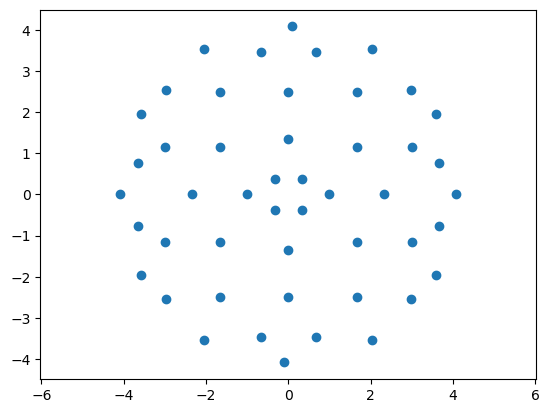

In [10]:
plt.scatter(df['X'][idx_mirror_f1], df['Y'][idx_mirror_f1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

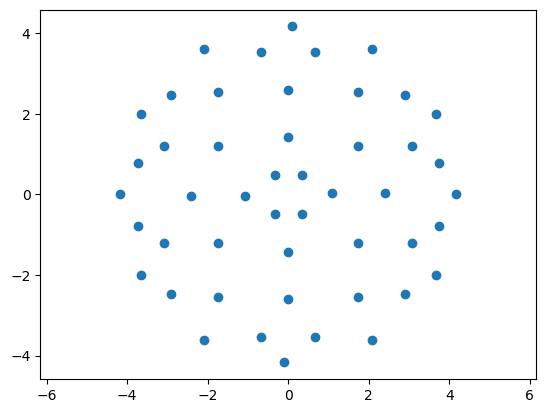

In [11]:
plt.scatter(df['X'][idx_mirror_b1], df['Y'][idx_mirror_b1])
plt.axis('equal')

(-4.590848899999999, 4.590848899999999, -4.5896587, 4.5896587)

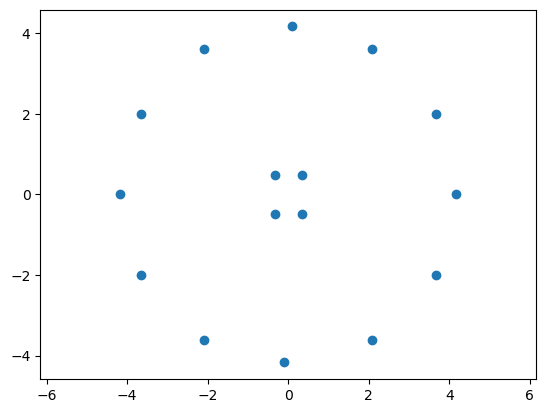

In [12]:
plt.scatter(df['X'][idx_mirror_m1], df['Y'][idx_mirror_m1])
plt.axis('equal')

In [36]:
#starting from a few hours before turning on the suckulators
#ending a few hours after turning on the suckulators
import time
#current unix timestamp
start_time = time.time()-5*24*3600
end_time = time.time()
duration = end_time - start_time

In [38]:
nsamples = 500
tc, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/tc_temperature/value', duration_in_s=duration, samples=nsamples)

m1_s1_thermal_ctrl/i/tc_temperature/value
2025-01-05 15:24:14  duration =  432000.0001049042  s
(500, 6, 32)
(500, 192)


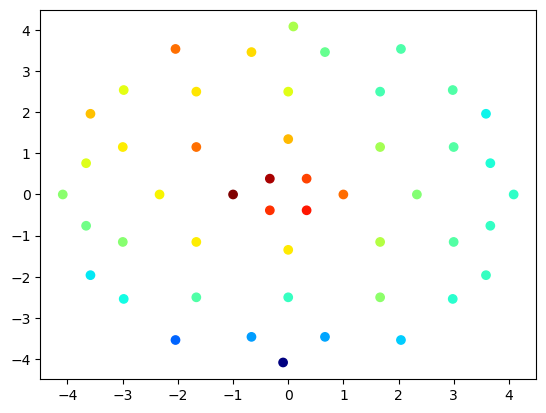

In [16]:
plt.scatter(tc_locs[idx_mirror_f,0], tc_locs[idx_mirror_f,1], c = tc[0,idx_mirror_f])

In [17]:
len(idx_mirror_f)
# https://github.com/CanisUrsa/ocs_m1_dcs/blob/master/src/etc/conf/m1_thermal_pkg/common/m1_s3_tc_position_conf.coffee
# https://github.com/CanisUrsa/ocs_m1_dcs/blob/master/src/etc/conf/m1_thermal_pkg/common/m1_s3_tc_label_conf.coffee

192

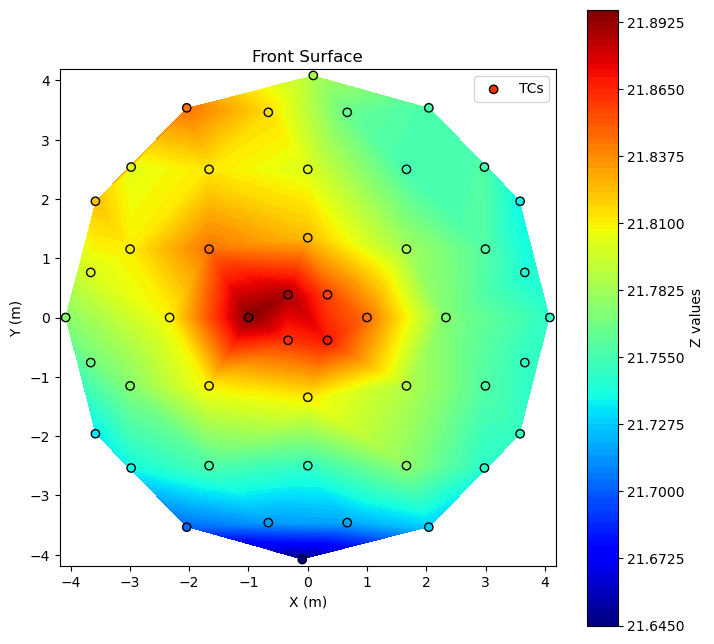

In [18]:
x = tc_locs[idx_mirror_f][:,0] 
y = tc_locs[idx_mirror_f][:,1]
z = tc[0,idx_mirror_f]

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Interpolate z-values to the grid
zi = griddata((x, y), z, (xi, yi), method='linear')

# Apply the circular mask
zi[~mask] = np.nan  # Set values outside the circle to NaN

# Plot the result
plt.figure(figsize=(8, 8))
contour = plt.contourf(xi, yi, zi, levels=100, cmap='jet')
plt.colorbar(contour, label='Z values')
plt.scatter(x, y, c=z, edgecolor='k', cmap='jet', label='TCs')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Front Surface')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.show()

In [39]:
tmirror, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/mirror_temperature/value', duration_in_s=duration, samples=nsamples)
tambient, tt = getDBData(start_time,'m1_s1_thermal_ctrl/i/ambient_temperature/value', duration_in_s=duration, samples=nsamples)

time_steps = tc.shape[0]  # Number of time steps

# Define the grid for interpolation
grid_size = 500  # Resolution of the grid
xi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
yi = np.linspace(-radius_of_CA, radius_of_CA, grid_size)
xi, yi = np.meshgrid(xi, yi)

# Create a circular mask for the given radius
mask = np.sqrt(xi**2 + yi**2) <= radius_of_CA

# Set the fixed color limits (vmin, vmax) for the contour plot
tc[tc>30] = np.nan
tc[tc<10] = np.nan
vmin = np.nanmin(tambient)  # Minimum value for the colorbar
vmax = np.nanmax(tmirror)  # Maximum value for the colorbar
#levels = np.linspace(vmin, vmax, 100)  # Explicitly define levels
vmax_index = np.nanargmax(tmirror)
tt0 = tt[vmax_index]
#print('vmin, vmax, ==== ', vmin, vmax)
cbar_span = 0.6 #deg

m1_s1_thermal_ctrl/i/mirror_temperature/value
2025-01-05 15:24:14  duration =  432000.0001049042  s
(500,)
(500,)
m1_s1_thermal_ctrl/i/ambient_temperature/value
2025-01-05 15:24:14  duration =  432000.0001049042  s
(500,)
(500,)


In [21]:
tambient.shape

(100,)

In [40]:
def update_plot(frame):

    if hasattr(update_plot, 'timeline'):
        update_plot.timeline.remove()
    #update_plot.timeline = ax1.axvline(x=(tt[frame]-tt0)/3600., color='r', linestyle='--', label='Current Time')
    update_plot.timeline = ax1.axvline(x=frame, color='r', linestyle='--', label='Current Time')
    ax1.set_title(f'Current Time = {datetime.datetime.fromtimestamp(tt[frame]).strftime("%Y-%m-%d %H:%M")} hours', fontsize=10)

    # Get the data for the current time step
    x = tc_locs[idx_mirror_f][:,0]
    y = tc_locs[idx_mirror_f][:,1]
    z = tc[frame, idx_mirror_f]  # Extract z-values for the current time step

    # Interpolate z-values to the grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    # Apply the circular mask
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    #ax3 for middle
    ax3.clear()
    x = tc_locs[idx_mirror_m][:,0]
    y = tc_locs[idx_mirror_m][:,1]
    z = tc[frame, idx_mirror_m]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax3.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('Middle, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax3.set_xlabel('X (m)')
    ax3.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar3'):
        update_plot.cbar3.remove()
    update_plot.cbar3 = fig.colorbar(contour, ax=ax3, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax3.scatter(x, y, c=z, edgecolor='k', vmin=np.min(levels), vmax=np.max(levels), cmap='jet', label='TCs')
    #ax3.legend(loc='upper right')

    #ax4 for back
    ax4.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax4.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax4.set_aspect('equal', adjustable='box')
    ax4.set_title('Back, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax4.set_xlabel('X (m)')
    #ax4.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar4'):
        update_plot.cbar4.remove()
    update_plot.cbar4 = fig.colorbar(contour, ax=ax4, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax4.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax4.legend(loc='upper right')

    #ax5 for back-front
    ax5.clear()
    x = tc_locs[idx_mirror_b][:,0]
    y = tc_locs[idx_mirror_b][:,1]
    z = tc[frame, idx_mirror_b] - tc[frame, idx_mirror_f]
    zi = griddata((x, y), z, (xi, yi), method='linear')
    zi[~mask] = np.nan  # Set values outside the circle to NaN

    midpoint = np.nanmean(zi)
    levels = np.linspace(midpoint-cbar_span/2., midpoint+cbar_span/2., 100)
    zi = np.clip(zi, np.min(levels), np.max(levels))

    contour = ax5.contourf(xi, yi, zi, levels=levels, cmap='jet')
    ax5.set_aspect('equal', adjustable='box')
    ax5.set_title('Back-Front, Max - Min = %.2f Deg'%(np.nanmax(zi)-np.nanmin(zi)), fontsize=10)
    ax5.set_xlabel('X (m)')
    #ax5.set_ylabel('Y (m)')
    if hasattr(update_plot, 'cbar5'):
        update_plot.cbar5.remove()
    update_plot.cbar5 = fig.colorbar(contour, ax=ax5, format='%.2f')#, label='Temperature')  # Store the colorbar
    ax5.scatter(x, y, c=z, edgecolor='k', cmap='jet', vmin=np.min(levels), vmax=np.max(levels), label='TCs')
    #ax5.legend(loc='upper right')
    
    # Redraw the figure
    plt.draw()

In [23]:
np.mean(tc[:,idx_mirror_f], axis=1).shape

(100,)

In [24]:
tt[1:5]-tt[:4]

array([1699.99976254, 1700.00018954, 1680.00000215, 1699.9999845 ])

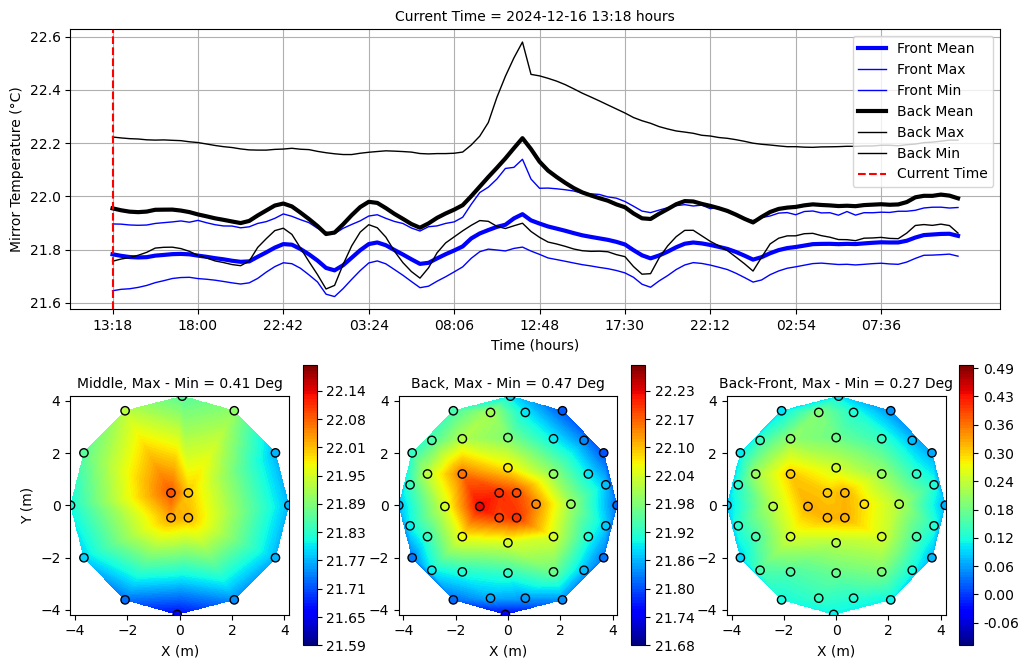

In [33]:
# Create the figure and axis for the subplots (2 panels)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))  # **Create 2 subplots: left (ax1) for tmirror, right (ax2) for contour plot**
#fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

ax1 = plt.subplot2grid(shape=(2, 3), loc=(0,0), colspan=3) #2D, deg C
ax3 = plt.subplot2grid(shape=(2, 3), loc=(1,0)) #front
ax4 = plt.subplot2grid(shape=(2, 3), loc=(1,1)) #back
ax5 = plt.subplot2grid(shape=(2, 3), loc=(1,2)) #back-front

# Plot the tmirror on ax1
time_labels = [datetime.datetime.fromtimestamp(ts).strftime('%H:%M') for ts in tt]
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_f], axis=1), label="Front Mean", color='blue', linestyle='-', linewidth=3)
ax1.plot(time_labels, np.max(tc[:,idx_mirror_f], axis=1), label="Front Max", color='blue', linestyle='-', linewidth=1)
ax1.plot(time_labels, np.min(tc[:,idx_mirror_f], axis=1), label="Front Min", color='blue', linestyle='-', linewidth=1)
ax1.plot(time_labels, np.mean(tc[:,idx_mirror_b], axis=1), label="Back Mean", color='k', linestyle='-', linewidth=3)
ax1.plot(time_labels, np.max(tc[:,idx_mirror_b], axis=1), label="Back Max", color='k', linestyle='-', linewidth=1)
ax1.plot(time_labels, np.min(tc[:,idx_mirror_b], axis=1), label="Back Min", color='k', linestyle='-', linewidth=1)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mirror Temperature (°C)')
#ax1.set_ylim(min(tambient)-0.2*(vmax-vmin), max(tmirror)+0.2*(vmax-vmin))  # Adjust y-axis based on your data
timeline = ax1.axvline(x=0, color='r', linestyle='--', label='Current Time')
ax1.legend(loc='upper right')
timeline.remove()
ax1.grid()
ax1.set_xticks(ticks=np.arange(0, len(time_labels), step=10), labels=[time_labels[i] for i in range(0, len(time_labels), 10)])

testing = 1
if testing:
    # Create the animation
    #for testing, 1 frame only, just to show the layout
    ani = animation.FuncAnimation(fig, update_plot, frames=1, repeat=False)
else:
    ani = animation.FuncAnimation(fig, update_plot, frames=time_steps, repeat=False)
    # Save the animation as an MP4 file
    ani.save('tc_surface.mp4', writer='ffmpeg', fps=5)  # Modify fps as needed

In [ ]:
np.sum(logical_index)

### Does the front and back TC's line up in x and y?

In [ ]:
np.max(tc_locs[idx_mirror_b][:,0]-tc_locs[idx_mirror_f][:,0])

In [ ]:
np.max(tc_locs[idx_mirror_b][:,1]-tc_locs[idx_mirror_f][:,1])